In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

# ==========================================
# 1. 参数设置与精确解 (Black-Scholes Formula)
# ==========================================

class BSParams:
    def __init__(self):
        self.K = 100.0      # 行权价
        self.T = 1.0        # 到期时间 (年)
        self.r = 0.03       # 无风险利率
        self.sigma = 0.30   # 波动率
        self.S_max = 500.0  # 价格截断上限 (通常取 3K-5K)

def exact_solution(S, tau, p):
    """
    Black-Scholes Call Option Closed-form Solution
    S: 标的资产价格 (可以是数组)
    tau: 距离到期的时间 (T - t)
    p: 参数对象
    """
    # 避免 S=0 时的 log(0) 错误
    S_safe = np.where(S > 1e-8, S, 1e-8)
    
    d1 = (np.log(S_safe / p.K) + (p.r + 0.5 * p.sigma**2) * tau) / (p.sigma * np.sqrt(tau))
    d2 = d1 - p.sigma * np.sqrt(tau)
    
    V = S * norm.cdf(d1) - p.K * np.exp(-p.r * tau) * norm.cdf(d2)
    
    # 修正 S=0 处的值
    if isinstance(S, np.ndarray):
        V[S <= 1e-8] = 0.0
    else:
        if S <= 1e-8: V = 0.0
    return V


Method          N_steps    Error (L2)      EOC       
--------------------------------------------------
--- BackwardEuler ---
BackwardEuler   100        4.42e-03      -         
BackwardEuler   200        2.21e-03      1.00      
BackwardEuler   400        1.11e-03      1.00      
BackwardEuler   800        5.55e-04      1.00      
BackwardEuler   1600       2.78e-04      1.00      
--- BDF2 ---
BDF2            100        4.10e-05      -         
BDF2            200        1.09e-05      1.91      
BDF2            400        3.49e-06      1.65      
BDF2            800        1.69e-06      1.05      
BDF2            1600       1.27e-06      0.41      


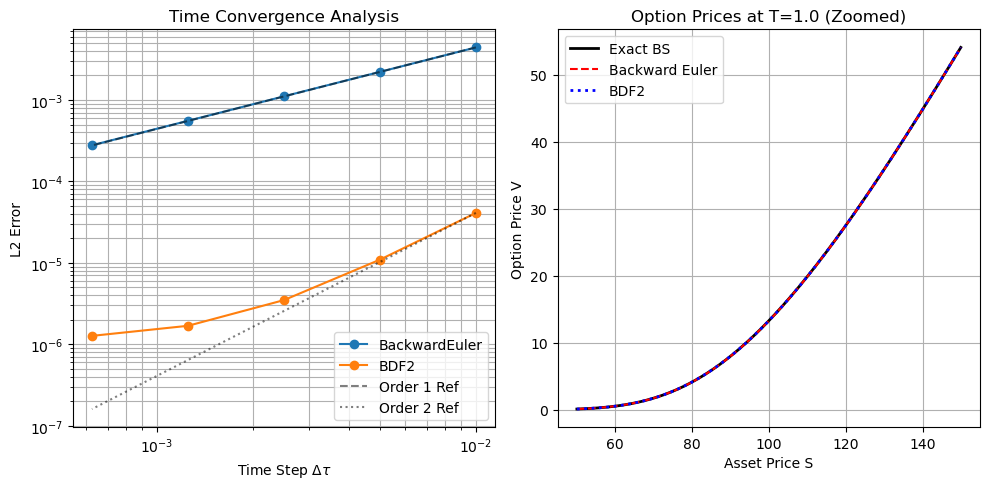

In [3]:

# ==========================================
# 2. 空间离散 (Method of Lines) -> 构建 Matrix A
# ==========================================

def construct_system(M, p):
    """
    在空间网格 S_i = i * dS 上离散 Black-Scholes PDE
    得到 dV/dtau = A * V + b(tau)
    
    M: 空间网格区间数 (节点数 M+1)
    返回: 稀疏矩阵 A (内部节点大小 M-1 x M-1), 空间步长 dS, 网格点 S_inner
    """
    dS = p.S_max / M
    S_inner = np.linspace(dS, p.S_max - dS, M - 1) # 仅包含内部节点 S_1 ... S_{M-1}
    
    # 构造三对角矩阵系数
    # PDE: V_tau = 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V
    # 离散格式 (Central Difference):
    # V_S  ~ (V_{i+1} - V_{i-1}) / 2dS
    # V_SS ~ (V_{i+1} - 2V_i + V_{i-1}) / dS^2
    
    # 整理后 V_i 的系数:
    # Coeff(V_{i-1}): alpha = 0.5*sigma^2*S^2/dS^2 - 0.5*r*S/dS
    # Coeff(V_{i}):   beta  = -sigma^2*S^2/dS^2 - r
    # Coeff(V_{i+1}): gamma = 0.5*sigma^2*S^2/dS^2 + 0.5*r*S/dS
    
    alpha = 0.5 * p.sigma**2 * (S_inner/dS)**2 - 0.5 * p.r * (S_inner/dS)
    beta  = -p.sigma**2 * (S_inner/dS)**2 - p.r
    gamma = 0.5 * p.sigma**2 * (S_inner/dS)**2 + 0.5 * p.r * (S_inner/dS)
    
    # 组装稀疏矩阵 (Diagonals)
    # alpha 对应下对角线 (i, i-1), beta 对应主对角线 (i, i), gamma 对应上对角线 (i, i+1)
    # 注意: alpha 的第一个元素对应方程 1 的 V_0 (边界)，不在矩阵内，在 alpha[1:] 中取偏移
    # 这里直接构造三个对角线数组
    
    main_diag = beta
    lower_diag = alpha[1:] # 对应 A_{i, i-1}
    upper_diag = gamma[:-1] # 对应 A_{i, i+1}
    
    A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csc')
    
    return A, dS, S_inner, alpha, gamma

def get_boundary_vector(tau, p, M, alpha_full, gamma_full):
    """
    构建边界条件向量 b(tau)
    V(0, tau) = 0
    V(S_max, tau) = S_max - K * exp(-r * tau)
    """
    b = np.zeros(M - 1)
    
    # 左边界 (i=1 时涉及 V_0)
    # b[0] += alpha[0] * V_0.  Call Option V_0 = 0，所以这一项为0。
    
    # 右边界 (i=M-1 时涉及 V_M)
    V_M = p.S_max - p.K * np.exp(-p.r * tau)
    b[-1] += gamma_full[-1] * V_M
    
    return b

# ==========================================
# 3. 时间推进 Solver (Chapter 12 Methods)
# ==========================================

def solve_ode_system(method, N, M, p):
    """
    使用指定方法求解 ODE 系统
    N: 时间步数
    M: 空间步数
    """
    dtau = p.T / N
    A, dS, S_inner, alpha, gamma = construct_system(M, p)
    I = diags([1] * (M - 1), 0, format='csc')
    
    # 初始条件: Payoff at tau=0 (Expiry)
    # V(S, 0) = max(S - K, 0)
    V = np.maximum(S_inner - p.K, 0)
    
    # 存储结果用于后续分析
    # 为了简单，只存最终时刻的结果，或者如果需要画图存部分时刻
    
    # 预计算矩阵 (对于线性定常系数问题，矩阵是常数)
    # Backward Euler: (I - dt*A) V^{n+1} = V^n + dt*b^{n+1}
    # BDF2: (I - 2/3*dt*A) V^{n+1} = 4/3 V^n - 1/3 V^{n-1} + 2/3*dt*b^{n+1}
    
    if method == 'BackwardEuler':
        LHS = I - dtau * A
        
        for n in range(N):
            tau_next = (n + 1) * dtau
            b_next = get_boundary_vector(tau_next, p, M, alpha, gamma)
            RHS = V + dtau * b_next
            V = spsolve(LHS, RHS)
            
    elif method == 'BDF2':
        # BDF2 需要两步启动。第一步使用 Backward Euler
        # Step 1: Backward Euler
        LHS_BE = I - dtau * A
        tau_1 = 1 * dtau
        b_1 = get_boundary_vector(tau_1, p, M, alpha, gamma)
        V_prev = V.copy() # V_0
        V = spsolve(LHS_BE, V_prev + dtau * b_1) # V_1
        
        # Step 2 to N: BDF2
        LHS_BDF = I - (2.0/3.0) * dtau * A
        
        for n in range(1, N):
            tau_next = (n + 1) * dtau
            b_next = get_boundary_vector(tau_next, p, M, alpha, gamma)
            
            # BDF2 格式: 3 V^{n+1} - 4 V^n + V^{n-1} = 2 dt (A V^{n+1} + b^{n+1})
            # 移项整理得到上述 LHS_BDF 和下面的 RHS
            RHS = (4.0/3.0) * V - (1.0/3.0) * V_prev + (2.0/3.0) * dtau * b_next
            
            V_prev = V.copy()
            V = spsolve(LHS_BDF, RHS)
            
    return S_inner, V

# ==========================================
# 4. 主程序：收敛性分析与画图
# ==========================================

def run_analysis():
    p = BSParams()
    M = 10000 # 固定空间网格较密，以主要观察时间误差
    
    # --- 1. 收敛性测试 (EOC) ---
    print(f"{'Method':<15} {'N_steps':<10} {'Error (L2)':<15} {'EOC':<10}")
    print("-" * 50)
    
    methods = ['BackwardEuler', 'BDF2']
    step_sizes = [100, 200, 400, 800, 1600] # N values
    
    errors = {m: [] for m in methods}
    dtaus = []
    
    for method in methods:
        print(f"--- {method} ---")
        old_error = None
        for N in step_sizes:
            dtau = p.T / N
            if method == methods[0]: dtaus.append(dtau) # 只存一次
            
            # 数值解
            S_grid, V_num = solve_ode_system(method, N, M, p)
            
            # 精确解
            V_exact = exact_solution(S_grid, p.T, p)
            
            # 计算误差 (L2 Norm / sqrt(M) 近似积分范数)
            error = np.linalg.norm(V_num - V_exact) / np.sqrt(M)
            errors[method].append(error)
            
            # 计算 EOC
            eoc_str = "-"
            if old_error is not None:
                eoc = np.log(old_error / error) / np.log(2) # 步长减半，ratio 应该是 2^order
                eoc_str = f"{eoc:.2f}"
            
            print(f"{method:<15} {N:<10} {error:.2e}{'':<5} {eoc_str:<10}")
            old_error = error

    # --- 2. 绘图: Error vs Step Size (Log-Log) ---
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    for method in methods:
        plt.loglog(dtaus, errors[method], 'o-', label=method)
    
    # 添加参考斜率线
    plt.loglog(dtaus, [errors['BackwardEuler'][0] * (dt/dtaus[0])**1 for dt in dtaus], 'k--', alpha=0.5, label='Order 1 Ref')
    plt.loglog(dtaus, [errors['BDF2'][0] * (dt/dtaus[0])**2 for dt in dtaus], 'k:', alpha=0.5, label='Order 2 Ref')
    
    plt.xlabel(r'Time Step $\Delta \tau$')
    plt.ylabel('L2 Error')
    plt.title('Time Convergence Analysis')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # --- 3. 绘图: 价格曲线对比 (Visual check) ---
    plt.subplot(1, 2, 2)
    N_plot = 100
    S_grid, V_be = solve_ode_system('BackwardEuler', N_plot, M, p)
    S_grid, V_bdf = solve_ode_system('BDF2', N_plot, M, p)
    V_exact = exact_solution(S_grid, p.T, p)
    
    # 只画中间一段感兴趣的区域 (ATM 附近)
    mask = (S_grid > p.K * 0.5) & (S_grid < p.K * 1.5)
    
    plt.plot(S_grid[mask], V_exact[mask], 'k-', lw=2, label='Exact BS')
    plt.plot(S_grid[mask], V_be[mask], 'r--', label='Backward Euler')
    plt.plot(S_grid[mask], V_bdf[mask], 'b:', lw=2, label='BDF2')
    
    plt.xlabel('Asset Price S')
    plt.ylabel('Option Price V')
    plt.title(f'Option Prices at T={p.T} (Zoomed)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_analysis()

In [4]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
from datetime import datetime

# === 1. 定义 Black-Scholes 公式 (作为基准) ===
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# === 2. 获取真实数据 (以 Apple 为例) ===
ticker = "AAPL"
stock = yf.Ticker(ticker)

# 获取当前股价
current_price = stock.history(period="1d")['Close'].iloc[-1]
print(f"当前 {ticker} 股价: ${current_price:.2f}")

# 获取期权链 (选择一个未来的到期日)
# 这里的 index [5] 是随便选的，选一个大概 1-2 个月后到期的日期
expiration_date = stock.options[5] 
print(f"选择的期权到期日: {expiration_date}")

# 获取该日期的 Call Options 数据
opts = stock.option_chain(expiration_date)
calls = opts.calls

# === 3. 挑选一个行权价 (选最接近当前股价的 ATM 期权) ===
# 筛选 Strike 在股价 +/- 5% 范围内的
atm_call = calls.iloc[(calls['strike'] - current_price).abs().argsort()[:1]]
strike_price = atm_call['strike'].values[0]
market_price = atm_call['lastPrice'].values[0]
implied_vol = atm_call['impliedVolatility'].values[0]

print(f"选定行权价 (K): ${strike_price}")
print(f"市场真实期权价格: ${market_price}")
print(f"市场隐含波动率 (IV): {implied_vol:.2%}")

# === 4. 准备参数输入你的 PDE Solver ===
# 计算距离到期的时间 T (以年为单位)
today = datetime.now()
exp_date = datetime.strptime(expiration_date, "%Y-%m-%d")
T_years = (exp_date - today).days / 365.0

# 无风险利率 r (可以使用 10年期美债收益率，约为 4.2%)
r_rate = 0.042 

print("\n--- 准备输入你的 PDE Solver ---")
print(f"S_max (建议): {strike_price * 4}")
print(f"K: {strike_price}")
print(f"T: {T_years:.4f}")
print(f"r: {r_rate}")
print(f"sigma (使用市场IV): {implied_vol:.4f}")

# === 5. 快速验证 (使用 BS 公式代替你的 PDE 跑一下预期结果) ===
model_price = bs_call_price(current_price, strike_price, T_years, r_rate, implied_vol)
print(f"\nBS 模型理论价: ${model_price:.2f}")
print(f"误差 (Model - Market): ${model_price - market_price:.2f}")

当前 AAPL 股价: $286.19
选择的期权到期日: 2026-01-09
选定行权价 (K): $285.0
市场真实期权价格: $9.15
市场隐含波动率 (IV): 23.10%

--- 准备输入你的 PDE Solver ---
S_max (建议): 1140.0
K: 285.0
T: 0.1014
r: 0.042
sigma (使用市场IV): 0.2310

BS 模型理论价: $9.62
误差 (Model - Market): $0.47
